In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of kernels in convolutional network
kernel_size1=3
strides=1
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating input dataset - mask
mask_dir = main_directory + '\\aeroCNN2Mask'
os.chdir(mask_dir)
mask_list = os.listdir(mask_dir)
mask_target = [file for file in mask_list if file.endswith('.csv')]

In [9]:
mask_df = pd.DataFrame()
for file in mask_target:
    data = pd.read_csv(file, header=None)
    mask_df = pd.concat([mask_df, data], axis=0)

In [10]:
x = mask_df.iloc[:,:].values

In [11]:
x_alligned = np.zeros((x.shape[0],x.shape[1]))
for i in range(0,144*2):
    if i%2==0:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:]
    else:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:].T


In [12]:
x = x_alligned.reshape((16*9,2,input_size,input_size))

In [14]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]
os.chdir(main_directory)

In [15]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [16]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [17]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [18]:
y.shape

(144, 2)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [20]:
x_train.shape

(100, 2, 100, 100)

In [21]:
y_train.shape

(100, 2)

In [22]:
tf.keras.backend.set_image_data_format('channels_first')

In [23]:
input_image = tf.keras.Input(shape=(2, input_size, input_size))

x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_flat = tf.keras.layers.Flatten()(x_)
x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_flat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=16, activation='relu', name='fc4')(x_fc3)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc4)
# AeroCNN-II based
model = tf.keras.Model(input_image, output_data)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 100, 100)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 100)     1900      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 50, 50)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 250000)            0         
                                                                 
 fc1 (Dense)                 (None, 128)               32000128  
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                             

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 17s 145ms/step - loss: 540.6212 - rmse: 23.2513 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 35ms/step - loss: 24.0353 - rmse: 4.9026 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 31ms/step - loss: 9.6719 - rmse: 3.1100 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 31ms/step - loss: 2.7998 - rmse: 1.6733 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 30ms/step - loss: 1.7182 - rmse: 1.3108 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 34ms/step - loss: 1.1661 - rmse: 1.0799 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 31ms/step - loss: 0.6240 - rmse: 0.7900 - lr: 0.0010
Epoch 8/5000
5/5 [==============================] - 0s 31ms/step - loss: 0.6173 - rmse: 0.7857 - lr: 0.0010
Epoch 9/5000
5/5 [==============================] - 0s 31ms/step - loss: 0.4616 - rmse: 0.6794 - lr: 0.0010
Epoch 10/5000
5/5 [===

5/5 [==============================] - 0s 8ms/step - loss: 0.1548 - rmse: 0.3935 - lr: 0.0010
Epoch 77/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.4294 - rmse: 0.6553 - lr: 0.0010
Epoch 78/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.3402 - rmse: 0.5833 - lr: 0.0010
Epoch 79/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.6612 - rmse: 0.8132 - lr: 0.0010
Epoch 80/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.6438 - rmse: 1.2821 - lr: 0.0010
Epoch 81/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.4077 - rmse: 1.1865 - lr: 0.0010
Epoch 82/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.7492 - rmse: 0.8656 - lr: 0.0010
Epoch 83/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.6689 - rmse: 0.8179 - lr: 0.0010
Epoch 84/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.5729 - rmse: 0.7569 - lr: 0.0010
Epoch 85/5000
5/5 [=======================

5/5 [==============================] - 0s 8ms/step - loss: 0.0053 - rmse: 0.0730 - lr: 0.0010
Epoch 152/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0599 - lr: 0.0010
Epoch 153/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0528 - lr: 0.0010
Epoch 154/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0416 - lr: 0.0010
Epoch 155/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0354 - lr: 0.0010
Epoch 156/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0440 - lr: 0.0010
Epoch 157/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0512 - lr: 0.0010
Epoch 158/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0381 - lr: 0.0010
Epoch 159/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0028 - rmse: 0.0529 - lr: 0.0010
Epoch 160/5000
5/5 [==============

5/5 [==============================] - 0s 8ms/step - loss: 0.0879 - rmse: 0.2966 - lr: 0.0010
Epoch 227/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0641 - rmse: 0.2532 - lr: 0.0010
Epoch 228/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0729 - rmse: 0.2700 - lr: 0.0010
Epoch 229/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0582 - rmse: 0.2412 - lr: 0.0010
Epoch 230/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0423 - rmse: 0.2056 - lr: 0.0010
Epoch 231/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0273 - rmse: 0.1653 - lr: 0.0010
Epoch 232/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0191 - rmse: 0.1382 - lr: 0.0010
Epoch 233/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0187 - rmse: 0.1369 - lr: 0.0010
Epoch 234/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0084 - rmse: 0.0919 - lr: 0.0010
Epoch 235/5000
5/5 [==============

Epoch 297/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.4278e-04 - rmse: 0.0307 - lr: 5.0000e-04
Epoch 298/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.3028e-04 - rmse: 0.0288 - lr: 5.0000e-04
Epoch 299/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0327 - lr: 5.0000e-04
Epoch 300/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.6350e-04 - rmse: 0.0294 - lr: 5.0000e-04
Epoch 301/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0320 - lr: 5.0000e-04
Epoch 302/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0368 - lr: 5.0000e-04
Epoch 303/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0334 - lr: 5.0000e-04
Epoch 304/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.8061e-04 - rmse: 0.0297 - lr: 5.0000e-04
Epoch 305/5000
5/5 [==============================] - 0s 24ms/step - loss: 6.994

5/5 [==============================] - 0s 8ms/step - loss: 7.0995e-04 - rmse: 0.0266 - lr: 5.0000e-04
Epoch 368/5000
5/5 [==============================] - 0s 49ms/step - loss: 5.2823e-04 - rmse: 0.0230 - lr: 5.0000e-04
Epoch 369/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.7535e-04 - rmse: 0.0240 - lr: 5.0000e-04
Epoch 370/5000
5/5 [==============================] - 0s 35ms/step - loss: 5.0876e-04 - rmse: 0.0226 - lr: 5.0000e-04
Epoch 371/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.0994e-04 - rmse: 0.0226 - lr: 5.0000e-04
Epoch 372/5000
5/5 [==============================] - 0s 8ms/step - loss: 6.0040e-04 - rmse: 0.0245 - lr: 5.0000e-04
Epoch 373/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.3217e-04 - rmse: 0.0231 - lr: 5.0000e-04
Epoch 374/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.9144e-04 - rmse: 0.0243 - lr: 5.0000e-04
Epoch 375/5000
5/5 [==============================] - 0s 32ms/step - loss: 4.

5/5 [==============================] - 0s 8ms/step - loss: 4.3387e-04 - rmse: 0.0208 - lr: 5.0000e-04
Epoch 438/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.9924e-04 - rmse: 0.0200 - lr: 5.0000e-04
Epoch 439/5000
5/5 [==============================] - 0s 7ms/step - loss: 4.1725e-04 - rmse: 0.0204 - lr: 5.0000e-04
Epoch 440/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.7244e-04 - rmse: 0.0217 - lr: 5.0000e-04
Epoch 441/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.3167e-04 - rmse: 0.0208 - lr: 5.0000e-04
Epoch 442/5000
5/5 [==============================] - 0s 25ms/step - loss: 3.7692e-04 - rmse: 0.0194 - lr: 5.0000e-04
Epoch 443/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.9860e-04 - rmse: 0.0200 - lr: 5.0000e-04
Epoch 444/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.7621e-04 - rmse: 0.0218 - lr: 5.0000e-04
Epoch 445/5000
5/5 [==============================] - 0s 7ms/step - loss: 4.01

5/5 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0317 - lr: 5.0000e-04
Epoch 508/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.4847e-04 - rmse: 0.0255 - lr: 5.0000e-04
Epoch 509/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.5716e-04 - rmse: 0.0275 - lr: 5.0000e-04
Epoch 510/5000
5/5 [==============================] - 0s 7ms/step - loss: 9.4145e-04 - rmse: 0.0307 - lr: 5.0000e-04
Epoch 511/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0337 - lr: 5.0000e-04
Epoch 512/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0324 - lr: 5.0000e-04
Epoch 513/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0401 - lr: 5.0000e-04
Epoch 514/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0381 - lr: 5.0000e-04
Epoch 515/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0359 - l

5/5 [==============================] - 0s 8ms/step - loss: 3.5114e-04 - rmse: 0.0187 - lr: 5.0000e-04
Epoch 578/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.3480e-04 - rmse: 0.0209 - lr: 5.0000e-04
Epoch 579/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.6170e-04 - rmse: 0.0257 - lr: 5.0000e-04
Epoch 580/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.8872e-04 - rmse: 0.0221 - lr: 5.0000e-04
Epoch 581/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.5374e-04 - rmse: 0.0235 - lr: 5.0000e-04
Epoch 582/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.7125e-04 - rmse: 0.0193 - lr: 5.0000e-04
Epoch 583/5000
5/5 [==============================] - 0s 24ms/step - loss: 2.6511e-04 - rmse: 0.0163 - lr: 5.0000e-04
Epoch 584/5000
5/5 [==============================] - 0s 8ms/step - loss: 3.1378e-04 - rmse: 0.0177 - lr: 5.0000e-04
Epoch 585/5000
5/5 [==============================] - 0s 7ms/step - loss: 2.69

Epoch 648/5000
5/5 [==============================] - 0s 7ms/step - loss: 8.5414e-04 - rmse: 0.0292 - lr: 5.0000e-04
Epoch 649/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.7005e-04 - rmse: 0.0192 - lr: 5.0000e-04
Epoch 650/5000
5/5 [==============================] - 0s 8ms/step - loss: 6.0685e-04 - rmse: 0.0246 - lr: 5.0000e-04
Epoch 651/5000
5/5 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0326 - lr: 5.0000e-04
Epoch 652/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.6897e-04 - rmse: 0.0311 - lr: 5.0000e-04
Epoch 653/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0363 - lr: 5.0000e-04
Epoch 654/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0355 - lr: 5.0000e-04
Epoch 655/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.0969e-04 - rmse: 0.0302 - lr: 5.0000e-04
Epoch 656/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.

5/5 [==============================] - 0s 8ms/step - loss: 2.3173e-04 - rmse: 0.0152 - lr: 2.5000e-04
Epoch 718/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.1530e-04 - rmse: 0.0147 - lr: 2.5000e-04
Epoch 719/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.1678e-04 - rmse: 0.0147 - lr: 2.5000e-04
Epoch 720/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.6121e-04 - rmse: 0.0127 - lr: 2.5000e-04
Epoch 721/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.4245e-04 - rmse: 0.0119 - lr: 2.5000e-04
Epoch 722/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.5167e-04 - rmse: 0.0123 - lr: 2.5000e-04
Epoch 723/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.4170e-04 - rmse: 0.0119 - lr: 2.5000e-04
Epoch 724/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.0086e-04 - rmse: 0.0173 - lr: 2.5000e-04
Epoch 725/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.461

5/5 [==============================] - 0s 7ms/step - loss: 1.2755e-04 - rmse: 0.0113 - lr: 2.5000e-04
Epoch 788/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.5714e-04 - rmse: 0.0125 - lr: 2.5000e-04
Epoch 789/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.9734e-04 - rmse: 0.0140 - lr: 2.5000e-04
Epoch 790/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.9017e-04 - rmse: 0.0170 - lr: 2.5000e-04
Epoch 791/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.4088e-04 - rmse: 0.0119 - lr: 2.5000e-04
Epoch 792/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.4908e-04 - rmse: 0.0122 - lr: 2.5000e-04
Epoch 793/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.7385e-04 - rmse: 0.0132 - lr: 2.5000e-04
Epoch 794/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.7139e-04 - rmse: 0.0131 - lr: 2.5000e-04
Epoch 795/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.950

5/5 [==============================] - 0s 8ms/step - loss: 1.9252e-04 - rmse: 0.0139 - lr: 2.5000e-04
Epoch 858/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.8568e-04 - rmse: 0.0136 - lr: 2.5000e-04
Epoch 859/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.0766e-04 - rmse: 0.0144 - lr: 2.5000e-04
Epoch 860/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.2285e-04 - rmse: 0.0149 - lr: 2.5000e-04
Epoch 861/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.1115e-04 - rmse: 0.0226 - lr: 2.5000e-04
Epoch 862/5000
5/5 [==============================] - 0s 8ms/step - loss: 3.1358e-04 - rmse: 0.0177 - lr: 2.5000e-04
Epoch 863/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.6745e-04 - rmse: 0.0164 - lr: 2.5000e-04
Epoch 864/5000
1/5 [=====>........................] - ETA: 0s - loss: 6.3722e-05 - rmse: 0.0080
Epoch 864: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
5/5 [=================

5/5 [==============================] - 0s 8ms/step - loss: 2.1268e-04 - rmse: 0.0146 - lr: 1.2500e-04
Epoch 926/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.6095e-04 - rmse: 0.0127 - lr: 1.2500e-04
Epoch 927/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.0286e-04 - rmse: 0.0101 - lr: 1.2500e-04
Epoch 928/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.3197e-04 - rmse: 0.0115 - lr: 1.2500e-04
Epoch 929/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.1063e-04 - rmse: 0.0105 - lr: 1.2500e-04
Epoch 930/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.0737e-04 - rmse: 0.0104 - lr: 1.2500e-04
Epoch 931/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.8102e-05 - rmse: 0.0099 - lr: 1.2500e-04
Epoch 932/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.1983e-04 - rmse: 0.0109 - lr: 1.2500e-04
Epoch 933/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.407

5/5 [==============================] - 0s 8ms/step - loss: 2.3581e-04 - rmse: 0.0154 - lr: 1.2500e-04
Epoch 996/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.0396e-04 - rmse: 0.0143 - lr: 1.2500e-04
Epoch 997/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.2354e-04 - rmse: 0.0111 - lr: 1.2500e-04
Epoch 998/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.1860e-04 - rmse: 0.0109 - lr: 1.2500e-04
Epoch 999/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.0437e-04 - rmse: 0.0102 - lr: 1.2500e-04
Epoch 1000/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.7617e-04 - rmse: 0.0133 - lr: 1.2500e-04
Epoch 1001/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.8623e-04 - rmse: 0.0136 - lr: 1.2500e-04
Epoch 1002/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.4088e-04 - rmse: 0.0155 - lr: 1.2500e-04
Epoch 1003/5000
5/5 [==============================] - 0s 7ms/step - loss: 2

5/5 [==============================] - 0s 7ms/step - loss: 1.2246e-04 - rmse: 0.0111 - lr: 6.2500e-05
Epoch 1064/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.1027e-05 - rmse: 0.0090 - lr: 6.2500e-05
Epoch 1065/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.9395e-05 - rmse: 0.0095 - lr: 6.2500e-05
Epoch 1066/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.6510e-05 - rmse: 0.0093 - lr: 6.2500e-05
Epoch 1067/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.9638e-05 - rmse: 0.0100 - lr: 6.2500e-05
Epoch 1068/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.7366e-05 - rmse: 0.0088 - lr: 6.2500e-05
Epoch 1069/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.7427e-05 - rmse: 0.0099 - lr: 6.2500e-05
Epoch 1070/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.1558e-04 - rmse: 0.0108 - lr: 6.2500e-05
Epoch 1071/5000
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 7ms/step - loss: 1.6744e-04 - rmse: 0.0129 - lr: 6.2500e-05
Epoch 1133/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.0982e-04 - rmse: 0.0105 - lr: 6.2500e-05
Epoch 1134/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.9940e-05 - rmse: 0.0089 - lr: 6.2500e-05
Epoch 1135/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.6193e-05 - rmse: 0.0087 - lr: 6.2500e-05
Epoch 1136/5000
5/5 [==============================] - 0s 7ms/step - loss: 8.8011e-05 - rmse: 0.0094 - lr: 6.2500e-05
Epoch 1137/5000
5/5 [==============================] - 0s 25ms/step - loss: 6.9552e-05 - rmse: 0.0083 - lr: 6.2500e-05
Epoch 1138/5000
5/5 [==============================] - 0s 28ms/step - loss: 6.3309e-05 - rmse: 0.0080 - lr: 6.2500e-05
Epoch 1139/5000
5/5 [==============================] - 0s 8ms/step - loss: 6.9715e-05 - rmse: 0.0083 - lr: 6.2500e-05
Epoch 1140/5000
5/5 [==============================] - 0s 7ms/step - l

5/5 [==============================] - 0s 7ms/step - loss: 9.5957e-05 - rmse: 0.0098 - lr: 6.2500e-05
Epoch 1202/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.3370e-05 - rmse: 0.0097 - lr: 6.2500e-05
Epoch 1203/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.0009e-05 - rmse: 0.0095 - lr: 6.2500e-05
Epoch 1204/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.5106e-04 - rmse: 0.0123 - lr: 6.2500e-05
Epoch 1205/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.6650e-04 - rmse: 0.0129 - lr: 6.2500e-05
Epoch 1206/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.6930e-04 - rmse: 0.0130 - lr: 6.2500e-05
Epoch 1207/5000
5/5 [==============================] - 0s 7ms/step - loss: 2.7139e-04 - rmse: 0.0165 - lr: 6.2500e-05
Epoch 1208/5000
5/5 [==============================] - 0s 7ms/step - loss: 3.2938e-04 - rmse: 0.0181 - lr: 6.2500e-05
Epoch 1209/5000
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 8ms/step - loss: 7.3139e-05 - rmse: 0.0086 - lr: 3.1250e-05
Epoch 1270/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.4902e-05 - rmse: 0.0087 - lr: 3.1250e-05
Epoch 1271/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.4418e-05 - rmse: 0.0097 - lr: 3.1250e-05
Epoch 1272/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.6367e-05 - rmse: 0.0087 - lr: 3.1250e-05
Epoch 1273/5000
5/5 [==============================] - 0s 7ms/step - loss: 8.7904e-05 - rmse: 0.0094 - lr: 3.1250e-05
Epoch 1274/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.7574e-05 - rmse: 0.0094 - lr: 3.1250e-05
Epoch 1275/5000
5/5 [==============================] - 0s 7ms/step - loss: 8.3449e-05 - rmse: 0.0091 - lr: 3.1250e-05
Epoch 1276/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.4646e-05 - rmse: 0.0097 - lr: 3.1250e-05
Epoch 1277/5000
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 8ms/step - loss: 1.4404e-04 - rmse: 0.0120 - lr: 3.1250e-05
Epoch 1339/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.4229e-04 - rmse: 0.0119 - lr: 3.1250e-05
Epoch 1340/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.7854e-04 - rmse: 0.0134 - lr: 3.1250e-05
Epoch 1341/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.9707e-04 - rmse: 0.0140 - lr: 3.1250e-05
Epoch 1342/5000
5/5 [==============================] - 0s 8ms/step - loss: 2.2148e-04 - rmse: 0.0149 - lr: 3.1250e-05
Epoch 1343/5000
5/5 [==============================] - 0s 7ms/step - loss: 1.9128e-04 - rmse: 0.0138 - lr: 3.1250e-05
Epoch 1344/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.8293e-04 - rmse: 0.0135 - lr: 3.1250e-05
Epoch 1345/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.2742e-04 - rmse: 0.0113 - lr: 3.1250e-05
Epoch 1346/5000
1/5 [=====>........................] - ETA: 0s - loss: 6

5/5 [==============================] - 0s 8ms/step - loss: 6.1571e-05 - rmse: 0.0078 - lr: 1.5625e-05
Epoch 1407/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.0923e-05 - rmse: 0.0084 - lr: 1.5625e-05
Epoch 1408/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.4567e-05 - rmse: 0.0086 - lr: 1.5625e-05
Epoch 1409/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.2009e-05 - rmse: 0.0079 - lr: 1.5625e-05
Epoch 1410/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.3577e-05 - rmse: 0.0080 - lr: 1.5625e-05
Epoch 1411/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.9099e-05 - rmse: 0.0083 - lr: 1.5625e-05
Epoch 1412/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.2114e-05 - rmse: 0.0085 - lr: 1.5625e-05
Epoch 1413/5000
5/5 [==============================] - 0s 8ms/step - loss: 6.3081e-05 - rmse: 0.0079 - lr: 1.5625e-05
Epoch 1414/5000
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 7ms/step - loss: 6.6931e-05 - rmse: 0.0082 - lr: 1.5625e-05
Epoch 1476/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.2120e-05 - rmse: 0.0085 - lr: 1.5625e-05
Epoch 1477/5000
5/5 [==============================] - 0s 7ms/step - loss: 9.4456e-05 - rmse: 0.0097 - lr: 1.5625e-05
Epoch 1478/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.3912e-05 - rmse: 0.0086 - lr: 1.5625e-05
Epoch 1479/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.4688e-05 - rmse: 0.0080 - lr: 1.5625e-05
Epoch 1480/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.1378e-05 - rmse: 0.0084 - lr: 1.5625e-05
Epoch 1481/5000
5/5 [==============================] - 0s 8ms/step - loss: 9.0643e-05 - rmse: 0.0095 - lr: 1.5625e-05
Epoch 1482/5000
5/5 [==============================] - 0s 8ms/step - loss: 1.1310e-04 - rmse: 0.0106 - lr: 1.5625e-05
Epoch 1483/5000
5/5 [==============================] - 0s 7ms/step - los

5/5 [==============================] - 0s 8ms/step - loss: 5.1192e-05 - rmse: 0.0072 - lr: 7.8125e-06
Epoch 1544/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.2917e-05 - rmse: 0.0073 - lr: 7.8125e-06
Epoch 1545/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.0504e-05 - rmse: 0.0071 - lr: 7.8125e-06
Epoch 1546/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.0409e-05 - rmse: 0.0071 - lr: 7.8125e-06
Epoch 1547/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.9681e-05 - rmse: 0.0070 - lr: 7.8125e-06
Epoch 1548/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.4083e-05 - rmse: 0.0080 - lr: 7.8125e-06
Epoch 1549/5000
5/5 [==============================] - 0s 8ms/step - loss: 6.0056e-05 - rmse: 0.0077 - lr: 7.8125e-06
Epoch 1550/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.2957e-05 - rmse: 0.0073 - lr: 7.8125e-06
Epoch 1551/5000
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 8ms/step - loss: 5.2693e-05 - rmse: 0.0073 - lr: 7.8125e-06
Epoch 1613/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.2394e-05 - rmse: 0.0072 - lr: 7.8125e-06
Epoch 1614/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.1295e-05 - rmse: 0.0072 - lr: 7.8125e-06
Epoch 1615/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.1767e-05 - rmse: 0.0072 - lr: 7.8125e-06
Epoch 1616/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.4641e-05 - rmse: 0.0074 - lr: 7.8125e-06
Epoch 1617/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.2140e-05 - rmse: 0.0072 - lr: 7.8125e-06
Epoch 1618/5000
5/5 [==============================] - 0s 31ms/step - loss: 4.8437e-05 - rmse: 0.0070 - lr: 7.8125e-06
Epoch 1619/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.0061e-05 - rmse: 0.0071 - lr: 7.8125e-06
Epoch 1620/5000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 5.3857e-05 - rmse: 0.0073 - lr: 7.8125e-06
Epoch 1682/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.4109e-05 - rmse: 0.0074 - lr: 7.8125e-06
Epoch 1683/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.4335e-05 - rmse: 0.0074 - lr: 7.8125e-06
Epoch 1684/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.8095e-05 - rmse: 0.0069 - lr: 7.8125e-06
Epoch 1685/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.8983e-05 - rmse: 0.0077 - lr: 7.8125e-06
Epoch 1686/5000
5/5 [==============================] - 0s 27ms/step - loss: 4.6542e-05 - rmse: 0.0068 - lr: 7.8125e-06
Epoch 1687/5000
5/5 [==============================] - 0s 30ms/step - loss: 4.4624e-05 - rmse: 0.0067 - lr: 7.8125e-06
Epoch 1688/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.4549e-05 - rmse: 0.0074 - lr: 7.8125e-06
Epoch 1689/5000
5/5 [==============================] - 0s 8ms/step - l

5/5 [==============================] - 0s 8ms/step - loss: 6.6467e-05 - rmse: 0.0082 - lr: 7.8125e-06
Epoch 1751/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.3641e-05 - rmse: 0.0073 - lr: 7.8125e-06
Epoch 1752/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.8533e-05 - rmse: 0.0077 - lr: 7.8125e-06
Epoch 1753/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.6929e-05 - rmse: 0.0075 - lr: 7.8125e-06
Epoch 1754/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.5263e-05 - rmse: 0.0074 - lr: 7.8125e-06
Epoch 1755/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.3895e-05 - rmse: 0.0073 - lr: 7.8125e-06
Epoch 1756/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.9267e-05 - rmse: 0.0077 - lr: 7.8125e-06
Epoch 1757/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.5931e-05 - rmse: 0.0075 - lr: 7.8125e-06
Epoch 1758/5000
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 7ms/step - loss: 7.5634e-05 - rmse: 0.0087 - lr: 7.8125e-06
Epoch 1820/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.7717e-05 - rmse: 0.0076 - lr: 7.8125e-06
Epoch 1821/5000
5/5 [==============================] - 0s 8ms/step - loss: 6.3195e-05 - rmse: 0.0079 - lr: 7.8125e-06
Epoch 1822/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.2138e-05 - rmse: 0.0091 - lr: 7.8125e-06
Epoch 1823/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.3251e-05 - rmse: 0.0091 - lr: 7.8125e-06
Epoch 1824/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.4811e-05 - rmse: 0.0086 - lr: 7.8125e-06
Epoch 1825/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.4666e-05 - rmse: 0.0074 - lr: 7.8125e-06
Epoch 1826/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.3820e-05 - rmse: 0.0086 - lr: 7.8125e-06
Epoch 1827/5000
5/5 [==============================] - 0s 7ms/step - los

5/5 [==============================] - 0s 7ms/step - loss: 6.5811e-05 - rmse: 0.0081 - lr: 7.8125e-06
Epoch 1889/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.2912e-05 - rmse: 0.0079 - lr: 7.8125e-06
Epoch 1890/5000
5/5 [==============================] - 0s 7ms/step - loss: 7.8137e-05 - rmse: 0.0088 - lr: 7.8125e-06
Epoch 1891/5000
5/5 [==============================] - 0s 8ms/step - loss: 7.1627e-05 - rmse: 0.0085 - lr: 7.8125e-06
Epoch 1892/5000
5/5 [==============================] - 0s 8ms/step - loss: 8.1561e-05 - rmse: 0.0090 - lr: 7.8125e-06
Epoch 1893/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.6545e-05 - rmse: 0.0075 - lr: 7.8125e-06
Epoch 1894/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.7095e-05 - rmse: 0.0076 - lr: 7.8125e-06
Epoch 1895/5000
5/5 [==============================] - 0s 7ms/step - loss: 5.1021e-05 - rmse: 0.0071 - lr: 7.8125e-06
Epoch 1896/5000
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 8ms/step - loss: 5.1989e-05 - rmse: 0.0072 - lr: 3.9063e-06
Epoch 1957/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.5004e-05 - rmse: 0.0067 - lr: 3.9063e-06
Epoch 1958/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.8415e-05 - rmse: 0.0070 - lr: 3.9063e-06
Epoch 1959/5000
5/5 [==============================] - 0s 7ms/step - loss: 4.9127e-05 - rmse: 0.0070 - lr: 3.9063e-06
Epoch 1960/5000
5/5 [==============================] - 0s 7ms/step - loss: 4.8042e-05 - rmse: 0.0069 - lr: 3.9063e-06
Epoch 1961/5000
5/5 [==============================] - 0s 8ms/step - loss: 4.2379e-05 - rmse: 0.0065 - lr: 3.9063e-06
Epoch 1962/5000
5/5 [==============================] - 0s 8ms/step - loss: 5.2297e-05 - rmse: 0.0072 - lr: 3.9063e-06
Epoch 1963/5000
5/5 [==============================] - 0s 7ms/step - loss: 6.0044e-05 - rmse: 0.0077 - lr: 3.9063e-06
Epoch 1964/5000
5/5 [==============================] - 0s 8ms/step - los

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:01:43.627370


In [30]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_II_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

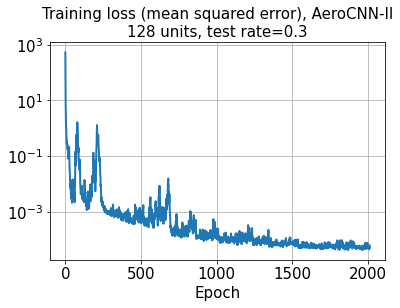

In [59]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error), AeroCNN-II\n{0} units, test rate={1}'.format(n_units, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

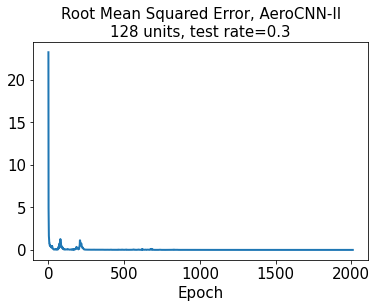

In [60]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\n{0} units, test rate={1}'.format(n_units, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

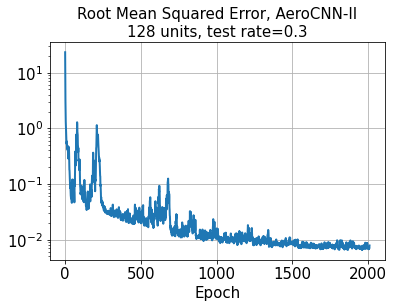

In [61]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\n{0} units, test rate={1}'.format(n_units, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 7ms/step - loss: 8.2548e-05 - rmse: 0.0091


In [35]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 16ms/step - loss: 0.0109 - rmse: 0.1044


In [36]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 3ms/step


In [37]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_AeroCNN_II_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [38]:
error_train_abs = np.abs(decoded_train - y_train)

In [39]:
error_test_abs = np.abs(decoded_test - y_test)

In [40]:
os.chdir(storage_dir)

In [41]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.010296094107872049


In [42]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.13205350210533826


In [43]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.11470336399534012


In [44]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.009362585702146074


In [45]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

1.0464988296309023


In [46]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.12750337999450018


In [47]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [48]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [49]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [50]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [51]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [52]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

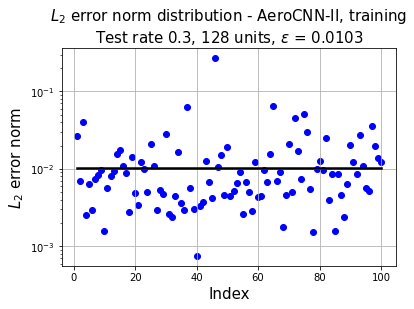

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

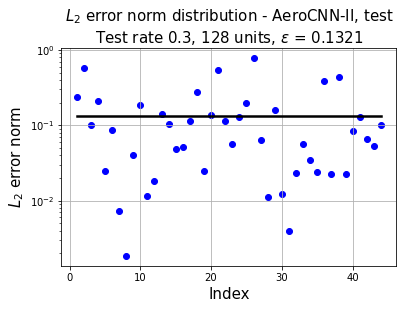

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                     n_units,
                                                                                                                     l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

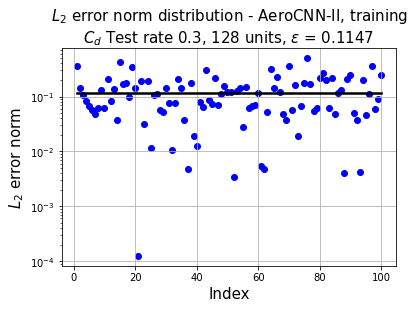

In [64]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

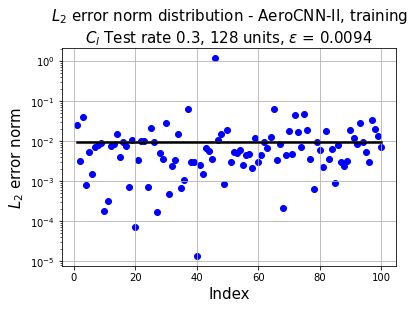

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

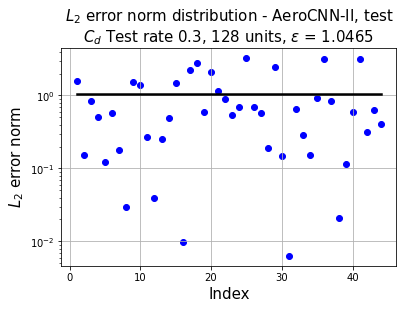

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

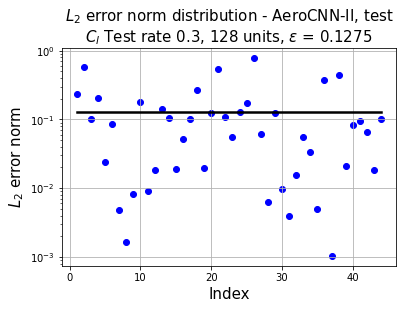

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()